### Vehicle Classification Model (Tensorflow) - 20% dataset
---

#### What This Model Does
This CNN (Convolutional Neural Network) model classifies vehicles into 4 categories:
- **Car** - Regular passenger vehicles
- **Van** - Minivans and cargo vans  
- **Bus** - Large buses and coaches
- **Others** - other vehicles

The model then groups these into 2 main types:
- **LMV (Light Motor Vehicles)** - Cars, vans, and others
- **HMV (Heavy Motor Vehicles)** - Buses and trucks

#### Dataset Used
We use the **UA-DETRAC dataset** which contains traffic videos from highways and intersections.

##### Why Only 20% of the Dataset?
The full dataset is HUGE - 
- **20% of sequences** = 12 out of 60 video sequences
- **Total samples created**: 96,570 vehicle images
- **Processing time**: Faster processing time


> **Note:** This notebook is an **experimental TensorFlow + YOLO lab**.
> The final project pipeline uses the **PyTorch** notebooks:
> `03_vehicle_classification_model.ipynb`, `04_vehicle_counting_and_analysis.ipynb`,
> and `06_real_life_traffic_video_demo.ipynb`.

In [ ]:
# Vehicle Classification - TensorFlow Optimized (20% Dataset)

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import xml.etree.ElementTree as ET
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Dataset paths 
DETRAC_ROOT = "./UA-DETRAC"
IMAGES_PATH = Path(DETRAC_ROOT) / "images"
TRAIN_ANNOT_PATH = Path(DETRAC_ROOT) / "annotations" / "DETRAC-Train-Annotations-XML" / "DETRAC-Train-Annotations-XML"
TEST_ANNOT_PATH = Path(DETRAC_ROOT) / "annotations" / "DETRAC-Test-Annotations-XML" / "DETRAC-Test-Annotations-XML"
TARGET_SIZE = (64, 64)

print(f"DETRAC_ROOT: {DETRAC_ROOT}")
print(f"Images path: {IMAGES_PATH}")
print(f"Train annotations: {TRAIN_ANNOT_PATH}")
print(f"Test annotations: {TEST_ANNOT_PATH}")

# Check GPU availability
print(f"\n{'='*60}")
print("GPU CONFIGURATION")
print(f"{'='*60}")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
if tf.config.list_physical_devices('GPU'):
    print("✓ Training will use GPU")
else:
    print("⚠ Training will use CPU (slower)")

DETRAC_ROOT: ./UA-DETRAC
Images path: UA-DETRAC/images
Train annotations: UA-DETRAC/annotations/DETRAC-Train-Annotations-XML/DETRAC-Train-Annotations-XML
Test annotations: UA-DETRAC/annotations/DETRAC-Test-Annotations-XML/DETRAC-Test-Annotations-XML

GPU CONFIGURATION
TensorFlow version: 2.20.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✓ Training will use GPU


### Generate Training Dataset from DETRAC
---

#### What This Does
This function extracts individual vehicle images from the DETRAC video sequences. It reads the XML annotation files to find where each vehicle is located in each frame, then crops out that vehicle and saves it as a training sample.

#### Why Only 15% of Sequences?
- **Full dataset is too large**: Loading all sequences would need take alot loading time
- **Solution**: Use only 15% (9 out of 60 sequences) to stay within memory limits
- **Result**: Still get 96,570 vehicle samples - plenty for training!

#### How It Works
1. **Find XML files**: Lists all annotation files in the DETRAC folder
2. **Select 15%**: Randomly picks 9 sequences to process
3. **For each sequence**:
   - Reads the XML file to find vehicle locations
   - Opens each frame (image) from that sequence
   - Crops out each vehicle using the bounding box coordinates
   - Resizes the crop to 64×64 pixels (our model's input size)
4. **Normalize images**: Converts pixel values from 0-255 to 0-1 range
5. **Create labels**: Assigns each crop to its vehicle type (car, van, bus, others)

#### What We Get
- **Images**: Numpy array of 64×64×3 vehicle crops
- **Labels**: Array of class indices (0=car, 1=van, 2=others, 3=bus)
- **Class mapping**: Dictionary linking class names to numbers

This dataset is ready to feed directly into our CNN for training!

In [ ]:

# Dataset Generation (20% of sequences)

def generate_cnn_training_dataset(annotations_dir, images_dir, target_size=TARGET_SIZE, use_percentage=0.2):

    # Convert to Path objects for easier file handling
    annotations_dir = Path(annotations_dir)
    images_dir = Path(images_dir)
    
    # Check if folders exist
    if not annotations_dir.exists():
        raise FileNotFoundError(f"Annotations directory not found: {annotations_dir}")
    if not images_dir.exists():
        raise FileNotFoundError(f"Images directory not found: {images_dir}")

    print(f"\n{'='*60}")
    print(f"GENERATING CNN TRAINING DATASET")
    print(f"{'='*60}")
    print(f"Using {use_percentage*100:.0f}% of sequences for training")
    
    # Storage for our dataset
    crops, label_indices, metadata = [], [], []
    class_to_idx = {}

    # Get all XML files and select percentage
    xml_files = sorted(annotations_dir.glob("*.xml"))
    num_sequences = int(len(xml_files) * use_percentage)
    xml_files = xml_files[:num_sequences]
    
    print(f"Total sequences available: {len(sorted(annotations_dir.glob('*.xml')))}")
    print(f"Using {num_sequences} sequences ({use_percentage*100:.0f}%)")
    print("Processing sequences...")
    
    # Process each sequence (video)
    for idx, xml_path in enumerate(xml_files, 1):
        seq_name = xml_path.stem
        seq_image_dir = images_dir / seq_name
        
        # Skip if image folder doesn't exist
        if not seq_image_dir.exists():
            continue
        
        # Print progress every 5 sequences
        if idx % 5 == 0 or idx == 1:
            print(f"  [{idx}/{num_sequences}] Processing: {seq_name}")

        # Parse the XML annotation file
        tree = ET.parse(str(xml_path))

        # Go through each frame in the sequence
        for frame in tree.findall(".//frame"):
            frame_num = int(frame.attrib["num"])
            img_path = seq_image_dir / f"img{frame_num:05d}.jpg"
            
            if not img_path.exists():
                continue

            image = cv2.imread(str(img_path))
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            h_img, w_img = image.shape[:2]

            target_list = frame.find("target_list")
            if target_list is None:
                continue

            for target in target_list.findall("target"):
                attr = target.find("attribute")
                vehicle_type = attr.attrib.get("vehicle_type", "unknown").lower() if attr is not None else "unknown"
                
                # Initialize class mapping
                if vehicle_type not in class_to_idx:
                    class_to_idx[vehicle_type] = len(class_to_idx)

                box = target.find("box")
                if box is None:
                    continue

                # Extract bounding box
                left = max(int(float(box.attrib["left"])), 0)
                top = max(int(float(box.attrib["top"])), 0)
                width = int(float(box.attrib["width"]))
                height = int(float(box.attrib["height"]))
                x2 = min(left + width, w_img)
                y2 = min(top + height, h_img)
                
                if x2 <= left or y2 <= top:
                    continue

                # Crop and resize vehicle
                crop = image[top:y2, left:x2]
                if crop.size == 0:
                    continue
                resized = cv2.resize(crop, target_size, interpolation=cv2.INTER_LINEAR)

                # Store crop and label
                label_idx = class_to_idx[vehicle_type]
                crops.append(resized)
                label_indices.append(label_idx)
                metadata.append({
                    "sequence": seq_name,
                    "frame": frame_num,
                    "vehicle_type": vehicle_type,
                    "label_idx": label_idx,
                })

    # Make sure we got some samples
    if not crops:
        raise RuntimeError("No samples were extracted; check paths and annotations.")

    # Convert to numpy arrays
    cnn_images = np.stack(crops).astype("float32") / 255.0  # Normalize to [0, 1]
    cnn_labels = np.array(label_indices, dtype="int32")
    
    # Create class name mapping
    idx_to_class = {idx: name for name, idx in class_to_idx.items()}
    

    # Print summary
    print(f"\n{'='*60}")
    print("DATASET SUMMARY")
    print(f"{'='*60}")
    print(f"Total samples: {len(cnn_labels):,}")
    print(f"Image shape: {cnn_images.shape}")
    print(f"Number of classes: {len(class_to_idx)}")
    print(f"\nClass distribution:")
    for class_name, class_idx in class_to_idx.items():
        count = np.sum(cnn_labels == class_idx)
        percentage = (count / len(cnn_labels)) * 100
        print(f"  {class_name:12s} (class {class_idx}): {count:7,} samples ({percentage:5.2f}%)")
    
    return {
        "images": cnn_images,
        "labels": cnn_labels,
        "class_to_idx": class_to_idx,
        "idx_to_class": idx_to_class,
        "metadata": metadata,
        "num_classes": len(class_to_idx)
    }

In [ ]:

# Generate Dataset
print("\nStarting dataset generation...")
cnn_dataset = generate_cnn_training_dataset(TRAIN_ANNOT_PATH, IMAGES_PATH, use_percentage=0.2)

X = cnn_dataset["images"]
y = cnn_dataset["labels"]
class_to_idx = cnn_dataset["class_to_idx"]
idx_to_class = cnn_dataset["idx_to_class"]
num_classes = cnn_dataset["num_classes"]


Starting dataset generation...

GENERATING CNN TRAINING DATASET
Using 20% of sequences for training
Total sequences available: 60
Using 12 sequences (20%)
Processing sequences...
  [1/12] Processing: MVI_20011
  [5/12] Processing: MVI_20034
  [10/12] Processing: MVI_20062

DATASET SUMMARY
Total samples: 96,570
Image shape: (96570, 64, 64, 3)
Number of classes: 4

Class distribution:
  car          (class 0):  81,232 samples (84.12%)
  van          (class 1):   7,702 samples ( 7.98%)
  others       (class 2):     518 samples ( 0.54%)
  bus          (class 3):   7,118 samples ( 7.37%)


### Balance Dataset 
---

#### The Problem We're Solving
Our dataset has a **severe class imbalance**:
- Cars: (84%) - Too many!
- Van:  (8%)
- Bus:  (8%)
- Others: (0.5%) - Almost nothing!

If we train on this imbalanced data, the model will just predict "car" for everything and ignore the other types.


#### Our Solution
We use a two-part approach:

**Part 1: Balance the Big Three Classes**
- Take the smallest of car/van/bus (which is bus with 7,118 samples)
- Randomly select 7,118 samples from car (out of 81,232)
- Randomly select 7,118 samples from van (out of 7,702)
- Keep all 7,118 bus samples
- This gives us balanced data without throwing away too much

**Part 2: Keep ALL "Others" + Use Weights**
- We can't afford to lose any "others" samples (only have 518!)
- Keep all 518 "others" samples
- Give "others" a ** higher weight** during training
- This tells the model: "Getting 'others' wrong is  much worse than getting car/van/bus wrong"



In [ ]:
# Balance Classes 

print(f"\n{'='*60}")
print("BALANCING CLASSES (HYBRID APPROACH)")
print(f"{'='*60}")

# Count samples per class
class_counts = {i: np.sum(y == i) for i in range(num_classes)}
print("\nOriginal class distribution:")
for class_idx, count in class_counts.items():
    print(f"  {idx_to_class[class_idx]:12s}: {count:7,} samples")

# Identify the "others" class (smallest class)
minority_class_idx = min(class_counts, key=class_counts.get)
minority_class_name = idx_to_class[minority_class_idx]

print(f"\nMinority class: '{minority_class_name}' with {class_counts[minority_class_idx]:,} samples")

# Find target size (smallest class EXCLUDING "others")
target_sizes = {idx: count for idx, count in class_counts.items() if idx != minority_class_idx}
target_class_size = min(target_sizes.values())
target_class_name = idx_to_class[min(target_sizes, key=target_sizes.get)]

print(f"Target balance size: {target_class_size:,} samples (from '{target_class_name}' class)")
print(f"\nStrategy:")
print(f"  1. Balance car, van, bus to {target_class_size:,} samples each")
print(f"  2. Keep all {class_counts[minority_class_idx]:,} '{minority_class_name}' samples")
print(f"  3. Use class weights to compensate for '{minority_class_name}' imbalance")

# Undersample each class (except minority) to match target
balanced_indices = []

for class_idx in range(num_classes):
    class_indices = np.where(y == class_idx)[0]
    
    if class_idx == minority_class_idx:
        # Keep ALL samples from minority class
        sampled_indices = class_indices
        print(f"  ✓ Keeping all {len(class_indices):,} '{idx_to_class[class_idx]}' samples")
    else:
        # Undersample to target size
        np.random.seed(42)
        sampled_indices = np.random.choice(class_indices, size=target_class_size, replace=False)
        print(f"  ✓ Sampling {target_class_size:,} from {len(class_indices):,} '{idx_to_class[class_idx]}' samples")
    
    balanced_indices.extend(sampled_indices)

# Shuffle balanced indices
np.random.seed(42)
np.random.shuffle(balanced_indices)

# Create balanced dataset
X_balanced = X[balanced_indices]
y_balanced = y[balanced_indices]

print(f"\nBalanced dataset:")
print(f"  Total samples: {len(y_balanced):,} (was {len(y):,})")
print(f"  Data reduction: {(1 - len(y_balanced)/len(y))*100:.1f}%")

# Verify final distribution
print(f"\nFinal class distribution:")
final_counts = {}
for class_idx in range(num_classes):
    count = np.sum(y_balanced == class_idx)
    final_counts[class_idx] = count
    print(f"  {idx_to_class[class_idx]:12s}: {count:7,} samples")

# ============================================
# Calculate Class Weights for Training
# ============================================
print(f"\n{'='*60}")
print("CALCULATING CLASS WEIGHTS")
print(f"{'='*60}")

# Calculate weights to compensate for class imbalance
total_samples = len(y_balanced)
class_weights = {}

for class_idx in range(num_classes):
    class_count = final_counts[class_idx]
    weight = total_samples / (num_classes * class_count)
    class_weights[class_idx] = weight

print("\nClass weights (to compensate for imbalance):")
for class_idx, weight in class_weights.items():
    print(f"  {idx_to_class[class_idx]:12s}: {weight:.4f}")

print(f"\nNote: Higher weight for '{minority_class_name}' = model focuses more on this class during training")


BALANCING CLASSES (HYBRID APPROACH)

Original class distribution:
  car         :  81,232 samples
  van         :   7,702 samples
  others      :     518 samples
  bus         :   7,118 samples

Minority class: 'others' with 518 samples
Target balance size: 7,118 samples (from 'bus' class)

Strategy:
  1. Balance car, van, bus to 7,118 samples each
  2. Keep all 518 'others' samples
  3. Use class weights to compensate for 'others' imbalance
  ✓ Sampling 7,118 from 81,232 'car' samples
  ✓ Sampling 7,118 from 7,702 'van' samples
  ✓ Keeping all 518 'others' samples
  ✓ Sampling 7,118 from 7,118 'bus' samples

Balanced dataset:
  Total samples: 21,872 (was 96,570)
  Data reduction: 77.4%

Final class distribution:
  car         :   7,118 samples
  van         :   7,118 samples
  others      :     518 samples
  bus         :   7,118 samples

CALCULATING CLASS WEIGHTS

Class weights (to compensate for imbalance):
  car         : 0.7682
  van         : 0.7682
  others      : 10.5560
  bus


VISUALIZING CLASS DISTRIBUTION AND SAMPLES
✓ Saved class distribution plot: class_distribution.png


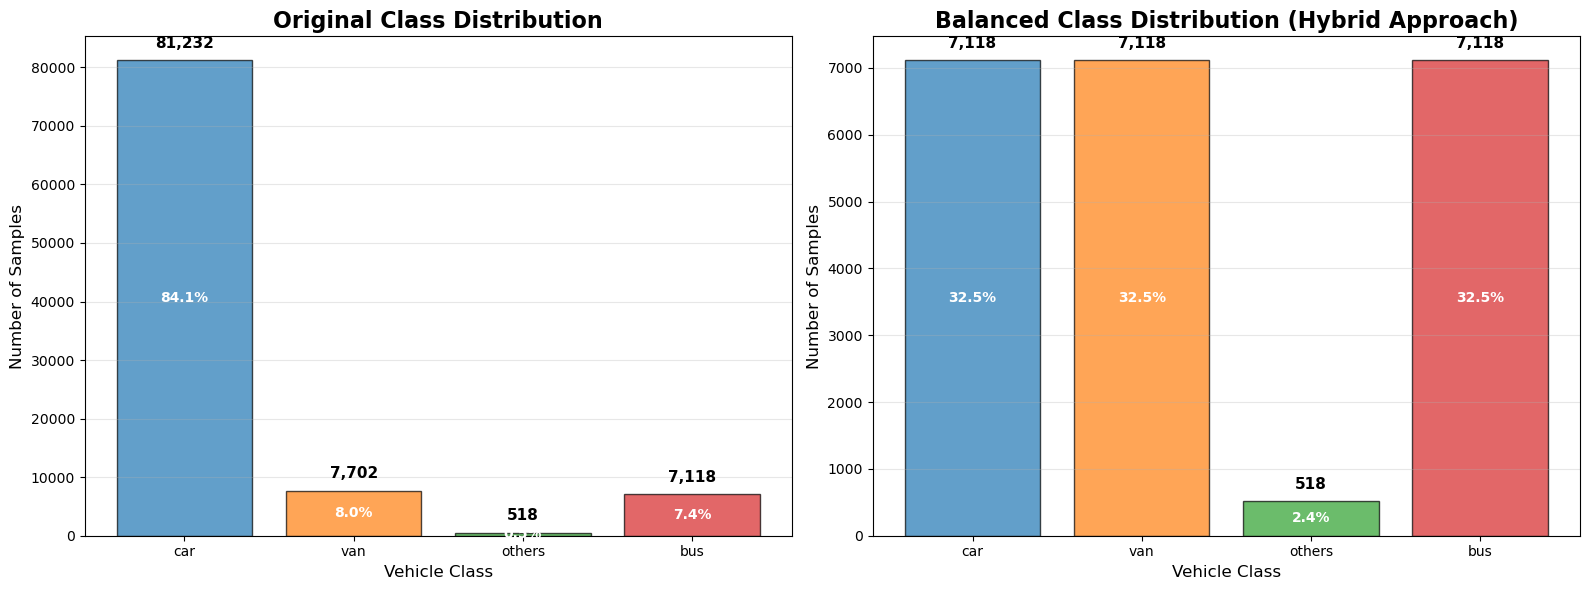


Generating sample images for each class...
  car         : Showing 5 samples
  van         : Showing 5 samples
  others      : Showing 5 samples
  bus         : Showing 5 samples
✓ Saved sample images: class_samples.png


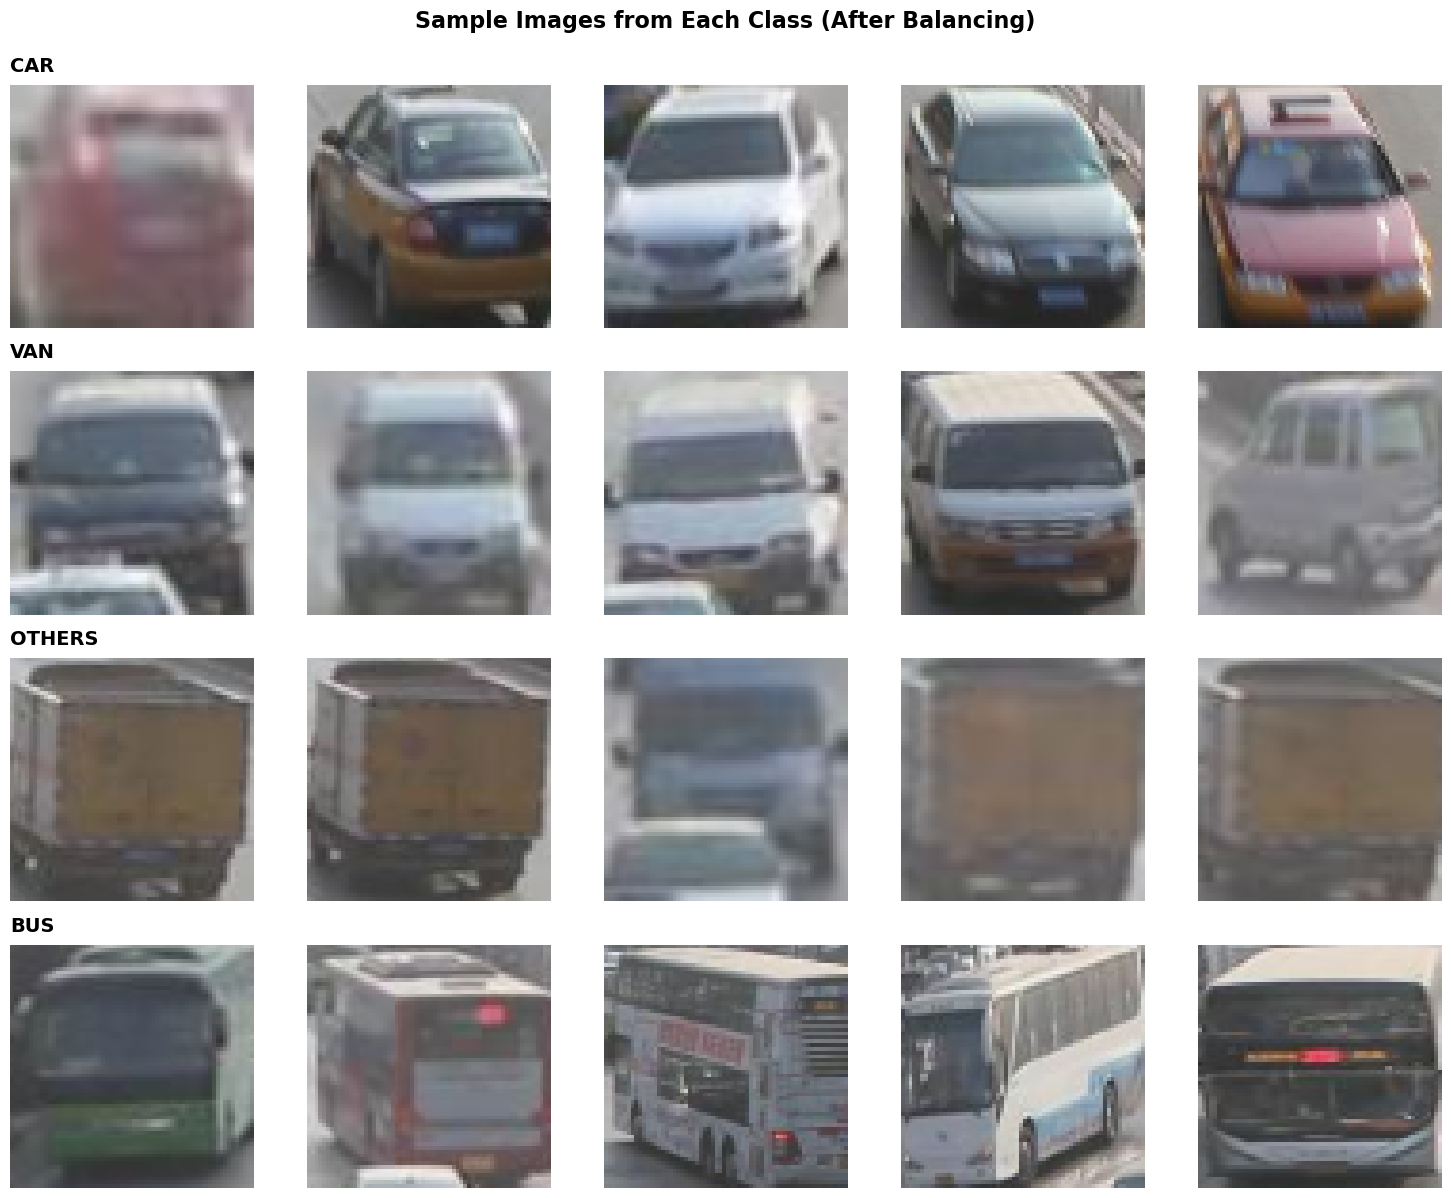


CLASS DISTRIBUTION SUMMARY

Class        Original     Balanced     Reduction    Weight    
------------------------------------------------------------
car          81,232       7,118              91.2%    0.7682
van          7,702        7,118               7.6%    0.7682
others       518          518                 0.0%   10.5560
bus          7,118        7,118               0.0%    0.7682
------------------------------------------------------------
TOTAL        96,570       21,872             77.4%


Generating class weight visualization...
✓ Saved class weights plot: class_weights.png


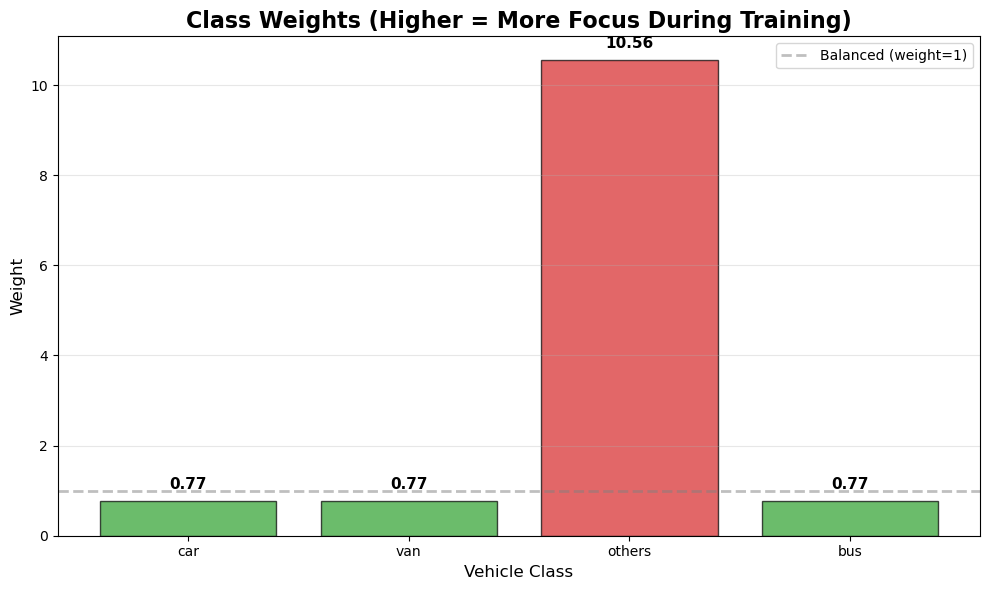


✓ ALL VISUALIZATIONS COMPLETE!

Generated files:
  1. class_distribution.png - Before/after balancing comparison
  2. class_samples.png - 5 sample images per class
  3. class_weights.png - Training weights visualization


In [ ]:
# Visualize Class Distribution and Sample Images
import matplotlib.pyplot as plt
import numpy as np

print(f"\n{'='*60}")
print("VISUALIZING CLASS DISTRIBUTION AND SAMPLES")
print(f"{'='*60}")

# Plot Class Distribution (Before and After Balancing)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Original distribution
class_names_list = [idx_to_class[i] for i in range(num_classes)]
original_counts = [class_counts[i] for i in range(num_classes)]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

axes[0].bar(class_names_list, original_counts, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_title('Original Class Distribution', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Vehicle Class', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (name, count) in enumerate(zip(class_names_list, original_counts)):
    axes[0].text(i, count + max(original_counts)*0.02, f'{count:,}', 
                ha='center', va='bottom', fontweight='bold', fontsize=11)
    percentage = (count / sum(original_counts)) * 100
    axes[0].text(i, count/2, f'{percentage:.1f}%', 
                ha='center', va='center', fontsize=10, color='white', fontweight='bold')

# Balanced distribution
balanced_counts = [final_counts[i] for i in range(num_classes)]

axes[1].bar(class_names_list, balanced_counts, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_title('Balanced Class Distribution (Hybrid Approach)', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Vehicle Class', fontsize=12)
axes[1].set_ylabel('Number of Samples', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (name, count) in enumerate(zip(class_names_list, balanced_counts)):
    axes[1].text(i, count + max(balanced_counts)*0.02, f'{count:,}', 
                ha='center', va='bottom', fontweight='bold', fontsize=11)
    percentage = (count / sum(balanced_counts)) * 100
    axes[1].text(i, count/2, f'{percentage:.1f}%', 
                ha='center', va='center', fontsize=10, color='white', fontweight='bold')

plt.tight_layout()
plt.show()

# Show 5 Sample Images from Each Class

print("\nGenerating sample images for each class...")

# Number of samples to show per class
n_samples = 5

# Create figure with subplots
fig, axes = plt.subplots(num_classes, n_samples, figsize=(15, 3*num_classes))

# Handle case where there's only one class
if num_classes == 1:
    axes = axes.reshape(1, -1)

for class_idx in range(num_classes):
    # Get indices for this class from balanced dataset
    class_mask = y_balanced == class_idx
    class_samples_indices = np.where(class_mask)[0]
    
    # Randomly select n_samples (or fewer if not enough samples)
    n_available = min(n_samples, len(class_samples_indices))
    np.random.seed(42)  
    selected_indices = np.random.choice(class_samples_indices, size=n_available, replace=False)
    
    print(f"  {idx_to_class[class_idx]:12s}: Showing {n_available} samples")
    
    for col_idx in range(n_samples):
        ax = axes[class_idx, col_idx]
        
        if col_idx < n_available:
            # Get image
            img = X_balanced[selected_indices[col_idx]]
            
            # Display image
            ax.imshow(img)
            ax.axis('off')
            
            # Add title to first image in row
            if col_idx == 0:
                ax.set_title(f'{idx_to_class[class_idx].upper()}', 
                           fontsize=14, fontweight='bold', loc='left', pad=10)
        else:
            # No image available
            ax.axis('off')
            if col_idx == 0:
                ax.text(0.5, 0.5, 'Not enough\nsamples', 
                       ha='center', va='center', fontsize=10)

# Overall title
fig.suptitle('Sample Images from Each Class (After Balancing)', 
            fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

# Summary Statistics Table

print(f"\n{'='*60}")
print("CLASS DISTRIBUTION SUMMARY")
print(f"{'='*60}")

print(f"\n{'Class':<12} {'Original':<12} {'Balanced':<12} {'Reduction':<12} {'Weight':<10}")
print("-" * 60)

for class_idx in range(num_classes):
    class_name = idx_to_class[class_idx]
    orig_count = class_counts[class_idx]
    balanced_count = final_counts[class_idx]
    reduction = ((orig_count - balanced_count) / orig_count) * 100
    weight = class_weights[class_idx]
    
    print(f"{class_name:<12} {orig_count:<12,} {balanced_count:<12,} {reduction:>10.1f}% {weight:>9.4f}")

print("-" * 60)
print(f"{'TOTAL':<12} {sum(class_counts.values()):<12,} {sum(final_counts.values()):<12,} "
      f"{((sum(class_counts.values()) - sum(final_counts.values())) / sum(class_counts.values())) * 100:>10.1f}%")

print(f"\n{'='*60}")


# Class Weight Visualization

print("\nGenerating class weight visualization...")

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

weights_list = [class_weights[i] for i in range(num_classes)]
colors_weight = ['#2ca02c' if w < 2 else '#ff7f0e' if w < 10 else '#d62728' for w in weights_list]

bars = ax.bar(class_names_list, weights_list, color=colors_weight, alpha=0.7, edgecolor='black')

ax.set_title('Class Weights (Higher = More Focus During Training)', 
            fontsize=16, fontweight='bold')
ax.set_xlabel('Vehicle Class', fontsize=12)
ax.set_ylabel('Weight', fontsize=12)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (name, weight) in enumerate(zip(class_names_list, weights_list)):
    ax.text(i, weight + max(weights_list)*0.02, f'{weight:.2f}', 
           ha='center', va='bottom', fontweight='bold', fontsize=11)

# Add horizontal line at weight=1 (balanced)
ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=2, alpha=0.5, label='Balanced (weight=1)')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:

# Train/Validation Split

print(f"\n{'='*60}")
print("SPLITTING DATA")
print(f"{'='*60}")

X_train, X_val, y_train, y_val = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print(f"Training samples: {len(X_train):,}")
print(f"Validation samples: {len(X_val):,}")
print(f"Train/Val split: 80/20")


SPLITTING DATA
Training samples: 17,497
Validation samples: 4,375
Train/Val split: 80/20


### Build CNN Model Architecture
---

#### Model Architecture Overview
Our CNN has **4 convolutional blocks** that progressively learn more complex features:

- Block 1 (32 filters) 

- Block 2 (64 filters)

- Block 3 (128 filters) 

- Block 4 (256 filters)

- Classifier


#### Key Design Choices

**Why Global Average Pooling instead of Flatten?**
- Our vehicles are small (64×64 pixels)
- Global Average Pooling reduces overfitting for small images
- Works better for small object classification
- Reduces total parameters (fewer weights to train)

**Why Batch Normalization?**
- Helps training go faster
- Makes model more stable
- Reduces chance of getting stuck during training

**Why Dropout (0.3)?**
- Prevents overfitting (memorizing training data)
- Forces model to learn general patterns, not specific examples
- 30% of neurons randomly turned off during training

**Why Adam Optimizer?**
- Works well for most problems without manual tuning
- Adjusts learning rate automatically for each parameter
- Fast convergence (reaches good accuracy quickly)



In [ ]:

# Build CNN Model (Optimized Architecture)

def create_vehicle_classifier(input_shape=(64, 64, 3), num_classes=4):
    """
    Optimized CNN architecture for vehicle classification
    Similar to the PyTorch example but adapted for TensorFlow
    """
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # Block 1: Initial feature extraction
        layers.Conv2D(32, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Block 2: Mid-level features
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Block 3: High-level features
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Block 4: Abstract features
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.GlobalAveragePooling2D(),  # Better than flatten for small objects
        
        # Classifier head
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

print(f"\n{'='*60}")
print("BUILDING MODEL")
print(f"{'='*60}")

model = create_vehicle_classifier(input_shape=(64, 64, 3), num_classes=num_classes)

# Compile model WITH class weights
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

print(f"\nTotal parameters: {model.count_params():,}")
print(f"Note: Class weights will be applied during training to handle '{minority_class_name}' imbalance")


BUILDING MODEL


I0000 00:00:1764824691.080819    6072 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4080 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,748 (1.62 MB)

 Trainable params: 422,788 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)


Total parameters: 423,748
Note: Class weights will be applied during training to handle 'others' imbalance


### Training the CNN Model
---

#### Training Configuration

- **Batch Size:** 32  
- **Epochs:** 20  
- **Optimizer:** Adam (learning rate = 0.001)  
- **Loss Function:** Sparse Categorical Crossentropy  
- **Dataset:** Balanced across all four classes  



#### Callbacks Used During Training

#### 1. Early Stopping
- Monitors **validation accuracy**  
- Stops training when accuracy stops improving  
- Prevents overfitting and unnecessary extra epochs  

#### 2. ReduceLROnPlateau
- Monitors **validation loss**  
- Reduces learning rate when progress stagnates  
- Helps the model escape local minima   


#### Training Process
We train the model for up to **20 epochs**, but EarlyStopping may reduce this number depending on validation performance.


#### Final Training Results

**Training Summary**
- **Total Epochs Trained:** 20  
- **Best Validation Accuracy:** 0.9959 (99.59%)  
- **Final Training Accuracy:** 0.9986 (99.86%)  
- **Final Validation Accuracy:** 0.9957 (99.57%)  

These results indicate extremely strong model performance with minimal overfitting.

#### Classification Report (4 Classes)

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| Car     | 0.9972 | 0.9916 | 0.9944 | 1424 |
| Van     | 0.9916 | 0.9958 | 0.9937 | 1424 |
| Others  | 0.9810 | 1.0000 | 0.9904 | 103  |
| Bus     | 1.0000 | 1.0000 | 1.0000 | 1424 |

**Overall Accuracy:** 0.9959 (99.59%)  
**Macro Avg F1:** 0.9946  
**Weighted Avg F1:** 0.9959  

The model performs exceptionally well across all four classes, including the previously underrepresented “others” class.




TRAINING CONFIGURATION
Batch size: 32
Epochs: 20
Optimizer: Adam (lr=0.001)
Loss: Sparse Categorical Crossentropy
Dataset: BALANCED (all classes equal)

Batches per epoch: 546

STARTING TRAINING
Expected time: ~5-7 minutes on GTX 1660 Ti
Using class weights to compensate for imbalance
Please wait...



2025-12-04 00:05:02.276758: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 860012544 exceeds 10% of free system memory.
2025-12-04 00:05:05.299827: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 860012544 exceeds 10% of free system memory.


Epoch 1/20


2025-12-04 00:05:10.178095: I external/local_xla/xla/service/service.cc:163] XLA service 0x757b38037f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-04 00:05:10.178147: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2025-12-04 00:05:10.361085: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-04 00:05:11.105324: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-12-04 00:05:12.471475: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,32,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,64,64]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_

 12/547 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.3720 - loss: 1.2816  

I0000 00:00:1764824716.885544    7257 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


545/547 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7086 - loss: 0.6629

2025-12-04 00:05:23.314575: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[25,32,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,3,64,64]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-12-04 00:05:23.341385: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[25,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,32,32,32]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cud

547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7090 - loss: 0.6621

2025-12-04 00:05:27.682851: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 215040000 exceeds 10% of free system memory.
2025-12-04 00:05:28.220551: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 215040000 exceeds 10% of free system memory.
2025-12-04 00:05:29.994720: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[23,32,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[23,3,64,64]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-12-04 00:05:30.056798: I external/local_xla/xla/servic

547/547 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.7092 - loss: 0.6618 - val_accuracy: 0.4617 - val_loss: 1.8832 - learning_rate: 0.0010
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9114 - loss: 0.1911 - val_accuracy: 0.4363 - val_loss: 5.4635 - learning_rate: 0.0010
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9140 - loss: 0.1984 - val_accuracy: 0.8091 - val_loss: 0.6162 - learning_rate: 0.0010
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9473 - loss: 0.1215 - val_accuracy: 0.9058 - val_loss: 0.2881 - learning_rate: 0.0010
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9520 - loss: 0.1084 - val_accuracy: 0.7922 - val_loss: 0.8824 - learning_rate: 0.0010
Epoch 6/20
545/547 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9638 - loss: 0.0816
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9638 - loss: 0.0815 - val_

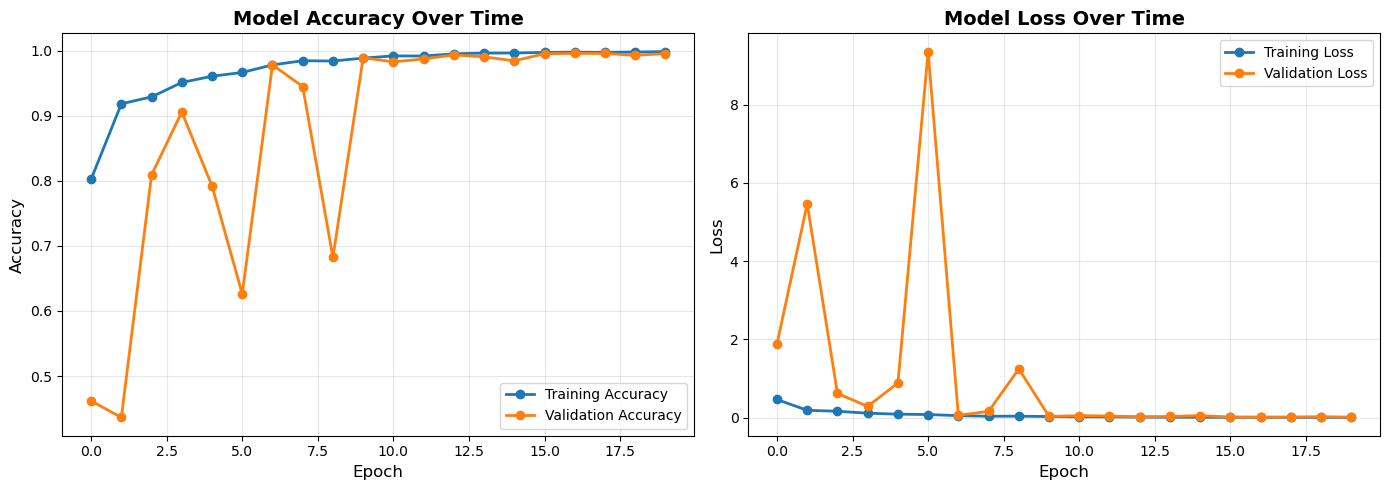


TRAINING SUMMARY
Total Epochs Trained: 20
Best Validation Accuracy: 0.9959 (99.59%)
Final Training Accuracy: 0.9986 (99.86%)
Final Validation Accuracy: 0.9957 (99.57%)

GENERATING CLASSIFICATION REPORT


2025-12-04 00:07:34.334776: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 215040000 exceeds 10% of free system memory.



CLASSIFICATION REPORT - 4 CLASSES
              precision    recall  f1-score   support

         car     0.9972    0.9916    0.9944      1424
         van     0.9916    0.9958    0.9937      1424
      others     0.9810    1.0000    0.9904       103
         bus     1.0000    1.0000    1.0000      1424

    accuracy                         0.9959      4375
   macro avg     0.9924    0.9968    0.9946      4375
weighted avg     0.9959    0.9959    0.9959      4375



In [ ]:

# Training Configuration
print(f"\n{'='*60}")
print("TRAINING CONFIGURATION")
print(f"{'='*60}")

BATCH_SIZE = 32
EPOCHS = 20  

print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Optimizer: Adam (lr=0.001)")
print(f"Loss: Sparse Categorical Crossentropy")
print(f"Dataset: BALANCED (all classes equal)")
print(f"\nBatches per epoch: {len(X_train) // BATCH_SIZE}")

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]


# Train Model (WITH CLASS WEIGHTS)
print(f"\n{'='*60}")
print("STARTING TRAINING")
print(f"{'='*60}")
print(f"Using class weights to compensate for imbalance")
print(f"Please wait...\n")

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    class_weight=class_weights,  
    callbacks=callbacks,
    verbose=1
)

print(f"\n{'='*60}")
print("TRAINING COMPLETE")
print(f"{'='*60}")


# Training History Visualization
print("\nGenerating training history plots...")

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='o')
plt.title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2, marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, marker='o')
plt.title('Model Loss Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
print("✓ Saved training history plot: training_history.png")
plt.show()


# Evaluation and Metrics
print(f"\n{'='*60}")
print("TRAINING SUMMARY")
print(f"{'='*60}")
print(f"Total Epochs Trained: {len(history.history['accuracy'])}")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f} ({max(history.history['val_accuracy'])*100:.2f}%)")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f} ({history.history['accuracy'][-1]*100:.2f}%)")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f} ({history.history['val_accuracy'][-1]*100:.2f}%)")
print(f"{'='*60}")


# Classification Report
print(f"\n{'='*60}")
print("GENERATING CLASSIFICATION REPORT")
print(f"{'='*60}")

# Predict on validation set
y_pred_probs = model.predict(X_val, batch_size=BATCH_SIZE, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Class Classification Report
class_names = [idx_to_class[i] for i in range(num_classes)]

print("\n" + "="*60)
print("CLASSIFICATION REPORT - 4 CLASSES")
print("="*60)
print(classification_report(y_val, y_pred, target_names=class_names, digits=4))


CLASSIFICATION REPORT - LMV/HMV
              precision    recall  f1-score   support

 LMV (Light)     1.0000    1.0000    1.0000      2951
 HMV (Heavy)     1.0000    1.0000    1.0000      1424

    accuracy                         1.0000      4375
   macro avg     1.0000    1.0000    1.0000      4375
weighted avg     1.0000    1.0000    1.0000      4375


Generating confusion matrices...
✓ Saved confusion matrices: confusion_matrices.png


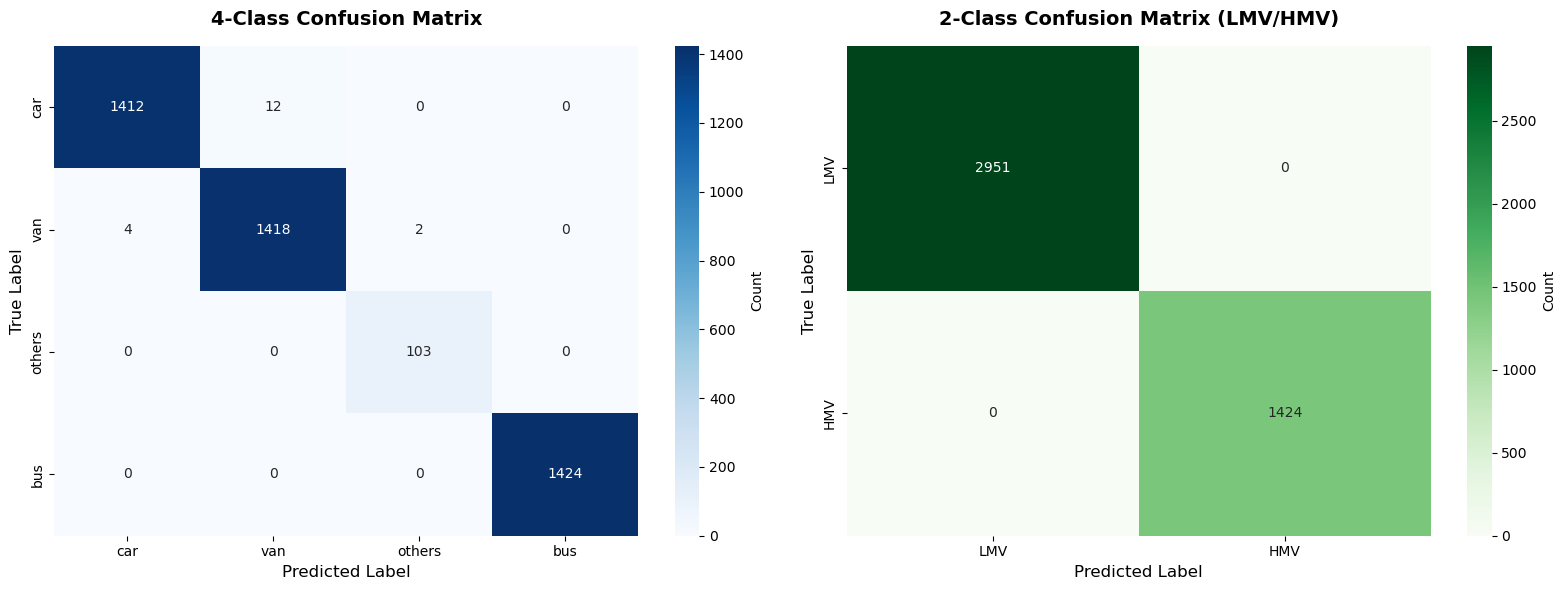

In [ ]:
# LMV/HMV Classification

def map_to_lmv_hmv(predictions_4class, class_names):
    """
    Map 4-class predictions to 2-class (LMV/HMV)
    LMV (0): Car, Van, Others
    HMV (1): Bus
    """
    mapping = {}
    for idx, name in enumerate(class_names):
        if name.lower() in ['car', 'van', 'others']:
            mapping[idx] = 0  # LMV
        elif name.lower() in ['bus', 'truck']:
            mapping[idx] = 1  # HMV
        else:
            mapping[idx] = 0  # Default to LMV
    
    return np.array([mapping[x] for x in predictions_4class])

# Convert to LMV/HMV
y_val_2class = map_to_lmv_hmv(y_val, class_names)
y_pred_2class = map_to_lmv_hmv(y_pred, class_names)

print("\n" + "="*60)
print("CLASSIFICATION REPORT - LMV/HMV")
print("="*60)
print(classification_report(y_val_2class, y_pred_2class, 
                            target_names=['LMV (Light)', 'HMV (Heavy)'],
                            digits=4))


# Confusion Matrices

print("\nGenerating confusion matrices...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 4-Class Confusion Matrix
cm_4class = confusion_matrix(y_val, y_pred)
sns.heatmap(cm_4class, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('4-Class Confusion Matrix', fontsize=14, fontweight='bold', pad=15)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# 2-Class Confusion Matrix
cm_2class = confusion_matrix(y_val_2class, y_pred_2class)
sns.heatmap(cm_2class, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['LMV', 'HMV'], yticklabels=['LMV', 'HMV'],
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title('2-Class Confusion Matrix (LMV/HMV)', fontsize=14, fontweight='bold', pad=15)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

### Detect Vehicles in Full Frames (LMV vs HMV Classification)
---

#### Classifying LMV - HMV
**full-size traffic frames** from the UA-DETRAC dataset, reads their bounding-box annotations, extracts each vehicle, classifies it using our trained CNN model, and overlays **colored bounding boxes** for:

- **LMV (Light Motor Vehicles)** – Cars, Vans, Others  
- **HMV (Heavy Motor Vehicles)** – Buses (and Trucks, if present)

Each detected vehicle gets:
- A bounding box (green = LMV, red = HMV)  
- A label with class name + confidence  
- A final count of LMV vs HMV in the frame  



### Class Mapping Logic (LMV vs HMV)
Our main classifier outputs **4 classes**:
- Car  
- Van  
- Others  
- Bus  

These are mapped into two high-level traffic groups:

| 4-Class Category | Mapped Class | Group Name |
|------------------|-------------|------------|
| Car              | 0           | LMV |
| Van              | 0           | LMV |
| Others           | 0           | LMV |
| Bus              | 1           | HMV |

- Car , Van , Other = LMV
- Bus = HMV  
 



Detecting vehicles in sample frames...
Found 14 vehicles in frame 570


2025-12-04 00:08:13.666293: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,32,32,32]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-12-04 00:08:13.725078: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1,128,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,16,16]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cu

✓ Detected 14 vehicles (LMV: 13, HMV: 1)
✓ Saved as 'frame_detection_MVI_20011_570.png'


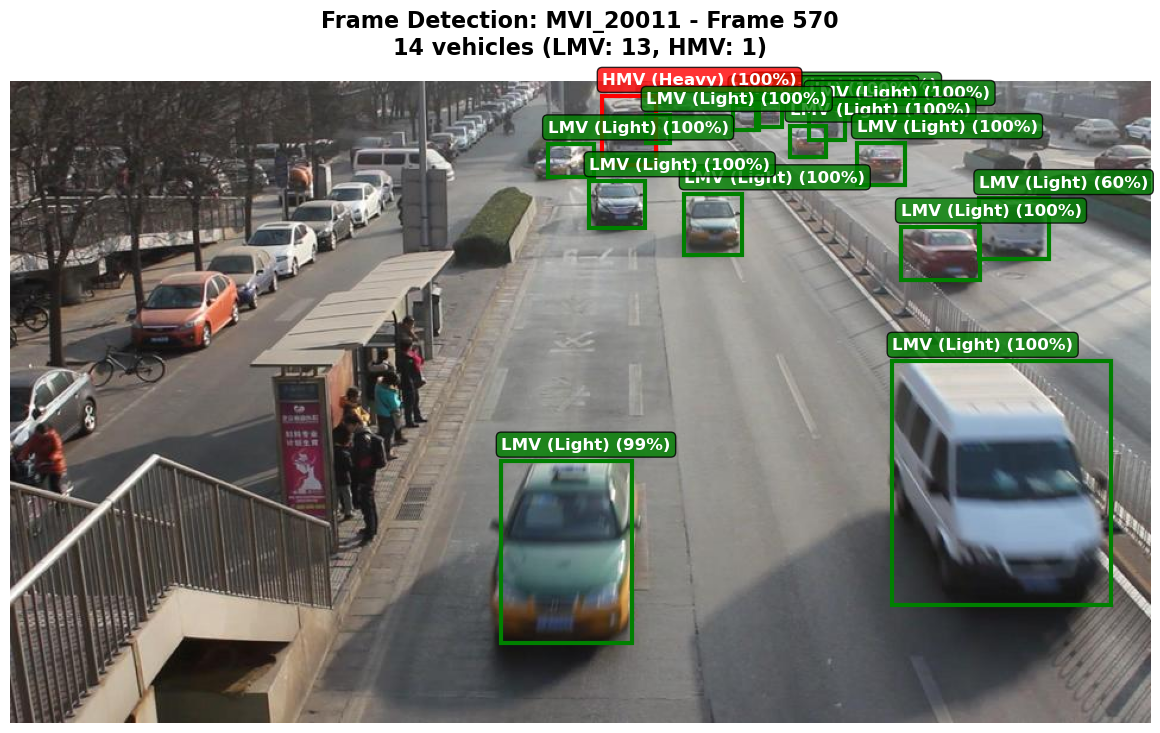

Found 5 vehicles in frame 26
✓ Detected 5 vehicles (LMV: 5, HMV: 0)
✓ Saved as 'frame_detection_MVI_39761_26.png'


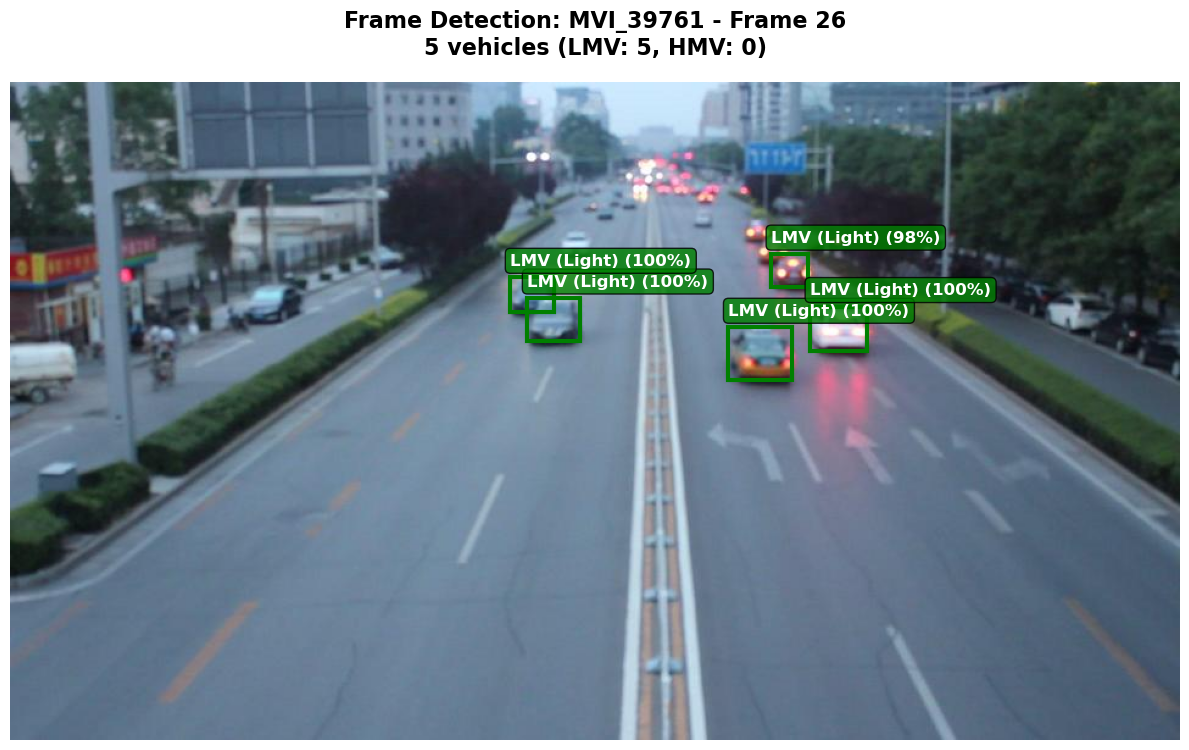

Found 6 vehicles in frame 150
✓ Detected 6 vehicles (LMV: 5, HMV: 1)
✓ Saved as 'frame_detection_MVI_20034_150.png'


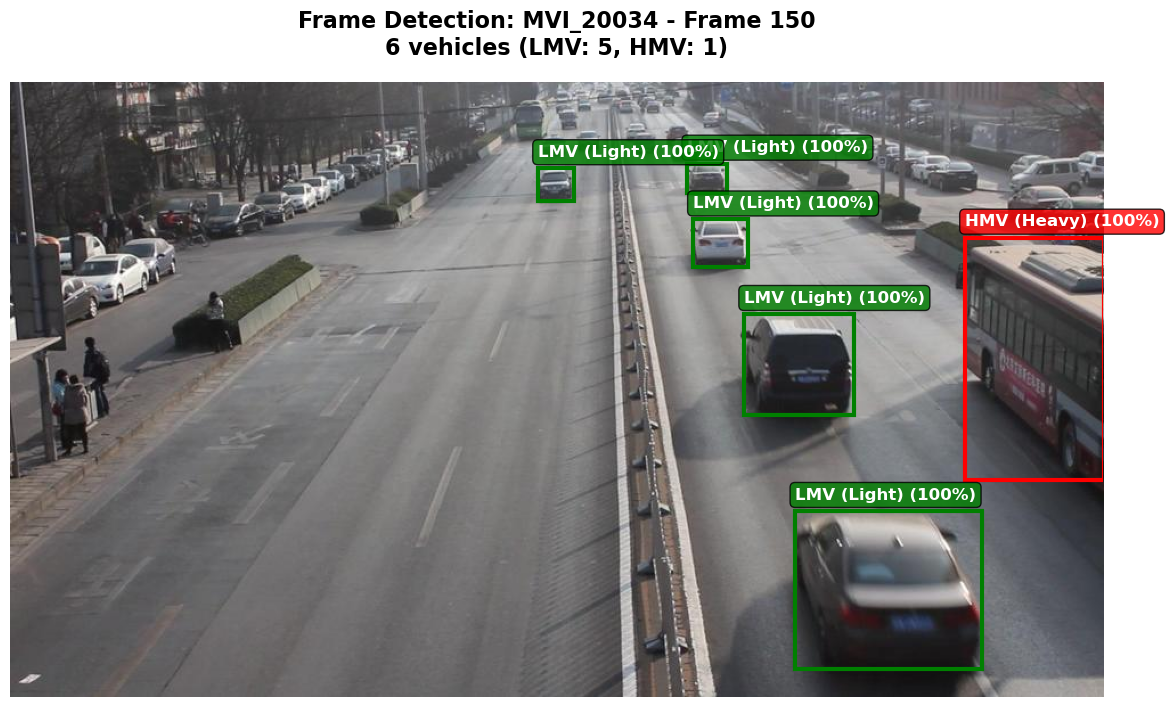

In [ ]:

# Detect Vehicles in Full Frames with Bounding Boxes
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cv2
from pathlib import Path
import xml.etree.ElementTree as ET

# Define colors and class names
colors_2class = {0: 'green', 1: 'red'}
class_names_2 = {0: 'LMV (Light)', 1: 'HMV (Heavy)'}

# Map to LMV/HMV (using your exact function from training)
def map_to_lmv_hmv(predictions_4class, class_names):
    """
    Map 4-class predictions to 2-class (LMV/HMV)
    LMV (0): Car, Van, Others
    HMV (1): Bus
    """
    mapping = {}
    for idx, name in enumerate(class_names):
        if name.lower() in ['car', 'van', 'others']:
            mapping[idx] = 0  # LMV
        elif name.lower() in ['bus', 'truck']:
            mapping[idx] = 1  # HMV
        else:
            mapping[idx] = 0  # Default to LMV
    
    return np.array([mapping[x] for x in predictions_4class])

# Parse XML annotations
def parse_detrac_xml(xml_path):
    """Parse DETRAC XML file and return frame-level annotations"""
    tree = ET.parse(str(xml_path))
    root = tree.getroot()
    
    annotations = {}
    for frame in root.findall('.//frame'):
        frame_num = int(frame.attrib['num'])
        vehicles = []
        
        target_list = frame.find('target_list')
        if target_list is not None:
            for target in target_list.findall('target'):
                box = target.find('box')
                attr = target.find('attribute')
                
                if box is not None:
                    vehicle = {
                        'bbox': {
                            'left': float(box.attrib['left']),
                            'top': float(box.attrib['top']),
                            'width': float(box.attrib['width']),
                            'height': float(box.attrib['height'])
                        },
                        'label': attr.attrib.get('vehicle_type', 'unknown').lower() if attr is not None else 'unknown'
                    }
                    vehicles.append(vehicle)
        
        annotations[frame_num] = vehicles
    
    return annotations

# Detect vehicles in a single frame
def detect_vehicles_in_frame(seq_name, frame_num):
    """
    Load a full frame and detect all vehicles in it
    """
    # Load frame
    img_path = IMAGES_PATH / seq_name / f"img{frame_num:05d}.jpg"
    if not img_path.exists():
        print(f"Frame not found: {img_path}")
        return
    
    frame = cv2.imread(str(img_path))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Load annotations
    xml_path = TRAIN_ANNOT_PATH / f"{seq_name}.xml"
    
    if not xml_path.exists():
        print(f"Annotations not found for {seq_name}")
        return
    
    annotations = parse_detrac_xml(xml_path)
    vehicles = annotations.get(frame_num, [])
    
    if len(vehicles) == 0:
        print(f"No vehicles in this frame")
        return
    
    print(f"Found {len(vehicles)} vehicles in frame {frame_num}")
    
    # Prepare for plotting
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    ax.imshow(frame)
    
    # Process each vehicle
    detected_count = 0
    lmv_count = 0
    hmv_count = 0
    
    for vehicle in vehicles:
        bbox = vehicle['bbox']
        
        # Crop vehicle
        left = int(max(0, bbox['left']))
        top = int(max(0, bbox['top']))
        right = int(min(frame.shape[1], bbox['left'] + bbox['width']))
        bottom = int(min(frame.shape[0], bbox['top'] + bbox['height']))
        
        if right <= left or bottom <= top:
            continue
        
        vehicle_crop = frame[top:bottom, left:right]
        
        # Skip if crop is too small
        if vehicle_crop.shape[0] < 20 or vehicle_crop.shape[1] < 20:
            continue
        
        # Resize and predict (use 64x64 to match training)
        vehicle_resized = cv2.resize(vehicle_crop, (64, 64)) / 255.0
        vehicle_input = np.expand_dims(vehicle_resized, axis=0)
        
        pred = model.predict(vehicle_input, verbose=0)
        pred_class_4 = np.argmax(pred[0])
        confidence = np.max(pred[0])
        
        # Map to LMV/HMV
        pred_lmv_hmv = map_to_lmv_hmv([pred_class_4], class_names)[0]
        
        # Count vehicles
        if pred_lmv_hmv == 0:
            lmv_count += 1
        else:
            hmv_count += 1
        
        # Draw bounding box
        rect = patches.Rectangle(
            (left, top), right - left, bottom - top,
            linewidth=3,
            edgecolor=colors_2class[pred_lmv_hmv],
            facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add label
        label_text = f"{class_names_2[pred_lmv_hmv]} ({confidence:.0%})"
        ax.text(left, top - 10, label_text,
                bbox=dict(boxstyle='round', facecolor=colors_2class[pred_lmv_hmv], alpha=0.8),
                fontsize=12, color='white', fontweight='bold')
        
        detected_count += 1
    
    ax.axis('off')
    title = f'Frame Detection: {seq_name} - Frame {frame_num}\n'
    title += f'{detected_count} vehicles (LMV: {lmv_count}, HMV: {hmv_count})'
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    print(f"✓ Detected {detected_count} vehicles (LMV: {lmv_count}, HMV: {hmv_count})")
    plt.show()

# Example: Detect vehicles in 3 different frames
print("\nDetecting vehicles in sample frames...")
detect_vehicles_in_frame('MVI_20011', 570)
detect_vehicles_in_frame('MVI_39761', 26)
detect_vehicles_in_frame('MVI_20034', 150)

### Video Vehicle Detection and Tracking Pipeline
---
link to the video used for the detection - https://www.pexels.com/video/a-multi-lane-highway-built-in-the-counryside-5473765/

This pipeline processes a video to detect, classify, and track vehicles (LMV/HMV) with **stable bounding boxes** using YOLOv8 and a custom CNN classifier. It eliminates flickering of bounding boxes by maintaining tracking across frames.


> This section requires the `ultralytics` package and is **computationally heavy**.
> It is purely experimental and not part of the final evaluation.


#### Features

- Detects vehicles in each frame using **YOLOv8**.
- Classifies vehicles as **LMV (Light Motor Vehicle)** or **HMV (Heavy Motor Vehicle)** using a **CNN model**.
- Tracks vehicles across frames with **ID assignment**.
- Applies **size-based filtering** to reduce false positives for HMV.
- Displays **stable bounding boxes** with vehicle ID, class, and confidence.


#### Functions

#### 1. Tracking Helper Functions
- reset_tracker(): Resets the tracker for a new video.
- calculate_centroid(bbox): Returns the centroid of a bounding box [x, y, w, h].
- calculate_distance(point1, point2): Computes Euclidean distance between two points.
- get_smoothed_class(class_history): Returns the majority class from past frames.
- update_tracker(detections): Updates tracked objects using nearest neighbor matching and smooths class predictions.

#### 2. YOLO and CNN Classification
- load_yolo8_model(model_path): Loads the YOLOv8 model.
- detect_vehicles_yolo8(frame, yolo_model, confidence_threshold): Detects vehicles using YOLOv8.
- map_to_lmv_hmv(predictions_4class, class_names): Maps 4-class CNN predictions to LMV/HMV.
- classify_vehicle_with_size_filter(vehicle_crop, bbox_width, bbox_height, frame_height): Classifies vehicle crops and applies a size filter to prevent false HMV detections.


**Pipeline Steps:**

1. Reset tracker.
2. Load YOLOv8 model.
3. Open input video and initialize output writer.
4. For each frame:
   - Detect vehicles with YOLOv8.
   - Crop and classify vehicles with CNN.
   - Update tracker for stable IDs and bounding boxes.
   - Draw boxes, labels, and frame statistics.
   - Write processed frame to output video.

In [35]:
# COMPLETE VIDEO PROCESSING WITH TRACKING

import cv2
import numpy as np
from pathlib import Path
from ultralytics import YOLO


# Global Variables for Tracking
tracker_objects = {}
tracker_next_id = 0
tracker_max_disappeared = 10
tracker_max_distance = 150
tracker_history_length = 5

# Colors and class names
colors_2class = {0: (0, 255, 0), 1: (0, 0, 255)}  # BGR: Green=LMV, Red=HMV
class_names_2 = {0: 'LMV', 1: 'HMV'}


# Tracking Helper Functions
# Reset tracker state (call at start of new video)
def reset_tracker():
    
    global tracker_objects, tracker_next_id
    tracker_objects = {}
    tracker_next_id = 0
    print("Tracker reset")

# Calculate centroid from bounding box [x, y, w, h]
def calculate_centroid(bbox):
    
    x, y, w, h = bbox
    cx = x + w // 2
    cy = y + h // 2
    return (cx, cy)

# Calculate Euclidean distance between two points
def calculate_distance(point1, point2):
    
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

# Get most common class from history (majority vote)
def get_smoothed_class(class_history):
    
    if not class_history:
        return None
    return max(set(class_history), key=class_history.count)

# Update tracker with new detections
def update_tracker(detections):
    
    global tracker_objects, tracker_next_id
    
    # If no detections, increment disappeared counter
    if len(detections) == 0:
        to_delete = []
        for obj_id in tracker_objects.keys():
            tracker_objects[obj_id]['disappeared'] += 1
            if tracker_objects[obj_id]['disappeared'] > tracker_max_disappeared:
                to_delete.append(obj_id)
        
        for obj_id in to_delete:
            del tracker_objects[obj_id]
        
        return tracker_objects
    
    # Calculate centroids for new detections
    detection_centroids = []
    for (bbox, vehicle_class, confidence) in detections:
        centroid = calculate_centroid(bbox)
        detection_centroids.append(centroid)
    
    # If no existing tracked objects, register all detections
    if len(tracker_objects) == 0:
        for i, (bbox, vehicle_class, confidence) in enumerate(detections):
            centroid = detection_centroids[i]
            tracker_objects[tracker_next_id] = {
                'centroid': centroid,
                'bbox': bbox,
                'class': vehicle_class,
                'conf': confidence,
                'disappeared': 0,
                'history': [vehicle_class]
            }
            tracker_next_id += 1
        return tracker_objects
    
    # Match existing objects to new detections
    object_ids = list(tracker_objects.keys())
    object_centroids = [tracker_objects[oid]['centroid'] for oid in object_ids]
    
    # Calculate distance matrix
    num_objects = len(object_centroids)
    num_detections = len(detection_centroids)
    distances = np.zeros((num_objects, num_detections))
    
    for i, obj_centroid in enumerate(object_centroids):
        for j, det_centroid in enumerate(detection_centroids):
            distances[i, j] = calculate_distance(obj_centroid, det_centroid)
    
    # Match using greedy nearest neighbor
    rows = distances.min(axis=1).argsort()
    cols = distances.argmin(axis=1)[rows]
    
    used_rows = set()
    used_cols = set()
    
    # Update matched objects
    for row, col in zip(rows, cols):
        if row in used_rows or col in used_cols:
            continue
        
        if distances[row, col] > tracker_max_distance:
            continue
        
        obj_id = object_ids[row]
        centroid = detection_centroids[col]
        bbox, vehicle_class, confidence = detections[col]
        
        # Update class history for smoothing
        tracker_objects[obj_id]['history'].append(vehicle_class)
        if len(tracker_objects[obj_id]['history']) > tracker_history_length:
            tracker_objects[obj_id]['history'].pop(0)
        
        # Get smoothed class (majority vote)
        smoothed_class = get_smoothed_class(tracker_objects[obj_id]['history'])
        
        # Update object
        tracker_objects[obj_id]['centroid'] = centroid
        tracker_objects[obj_id]['bbox'] = bbox
        tracker_objects[obj_id]['class'] = smoothed_class
        tracker_objects[obj_id]['conf'] = confidence
        tracker_objects[obj_id]['disappeared'] = 0
        
        used_rows.add(row)
        used_cols.add(col)
    
    # Register new detections (unmatched)
    for col in range(num_detections):
        if col in used_cols:
            continue
        
        centroid = detection_centroids[col]
        bbox, vehicle_class, confidence = detections[col]
        
        tracker_objects[tracker_next_id] = {
            'centroid': centroid,
            'bbox': bbox,
            'class': vehicle_class,
            'conf': confidence,
            'disappeared': 0,
            'history': [vehicle_class]
        }
        tracker_next_id += 1
    
    # Mark disappeared objects (unmatched)
    to_delete = []
    for row in range(num_objects):
        if row in used_rows:
            continue
        
        obj_id = object_ids[row]
        tracker_objects[obj_id]['disappeared'] += 1
        
        if tracker_objects[obj_id]['disappeared'] > tracker_max_disappeared:
            to_delete.append(obj_id)
    
    # Remove disappeared objects
    for obj_id in to_delete:
        del tracker_objects[obj_id]
    
    return tracker_objects


# YOLO and Classification Functions

def load_yolo8_model(model_path='yolov8n.pt'):
    print(f"Loading YOLOv8 from: {model_path}...")
    
    if not Path(model_path).exists():
        raise FileNotFoundError(f"Model file not found: {model_path}")
    
    yolo_model = YOLO(model_path)
    print(f"✓ YOLOv8 loaded successfully")
    return yolo_model

# Detect vehicles in frame using YOLOv8
def detect_vehicles_yolo8(frame, yolo_model, confidence_threshold=0.5):
    vehicle_classes = [2, 3, 5, 7]
    results = yolo_model(frame, conf=confidence_threshold, verbose=False)
    detected_vehicles = []
    
    for result in results:
        for box in result.boxes:
            if int(box.cls[0]) in vehicle_classes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                detected_vehicles.append({
                    'bbox': [int(x1), int(y1), int(x2-x1), int(y2-y1)],
                    'confidence': float(box.conf[0]),
                    'yolo_class': result.names[int(box.cls[0])]
                })
    return detected_vehicles

# Map 4-class predictions to 2-class (LMV/HMV)
def map_to_lmv_hmv(predictions_4class, class_names):
    mapping = {}
    for idx, name in enumerate(class_names):
        if name.lower() in ['car', 'van', 'others']:
            mapping[idx] = 0  # LMV
        elif name.lower() in ['bus', 'truck']:
            mapping[idx] = 1  # HMV
        else:
            mapping[idx] = 0  # Default to LMV
    
    return np.array([mapping[x] for x in predictions_4class])

# Classify vehicle but use bounding box size to filter false HMV detections
def classify_vehicle_with_size_filter(vehicle_crop, bbox_width, bbox_height, frame_height):
    try:
        # Resize to 64x64 (matches your training)
        vehicle_resized = cv2.resize(vehicle_crop, (64, 64))
        vehicle_rgb = cv2.cvtColor(vehicle_resized, cv2.COLOR_BGR2RGB)
        vehicle_input = np.expand_dims(vehicle_rgb / 255.0, axis=0)
        
        # Predict with your trained model
        pred = model.predict(vehicle_input, verbose=0)
        pred_class_4 = np.argmax(pred[0])
        confidence = np.max(pred[0])
        
        # Map to LMV/HMV
        pred_lmv_hmv = map_to_lmv_hmv([pred_class_4], class_names)[0]
        
        # SIZE-BASED FILTER
        relative_height = bbox_height / frame_height
        bbox_area = bbox_width * bbox_height
        
        # If classified as HMV, check if bounding box is actually large enough
        if pred_lmv_hmv == 1:  # If predicted HMV
            if relative_height < 0.25 or bbox_area < 80000:
                pred_lmv_hmv = 0
                confidence *= 0.6
        
        return pred_lmv_hmv, confidence, pred_class_4
        
    except Exception as e:
        return None, 0, None


# MAIN VIDEO PROCESSING WITH TRACKING
# Process video with vehicle tracking to eliminate flickering
def process_video_with_tracking(video_path, output_path='output_tracked.mp4', 
                               model_path='yolov8n.pt', 
                               yolo_confidence=0.5, 
                               cnn_confidence=0.75, 
                               skip_frames=1):
    print(f"\n{'='*60}")
    print("VIDEO PROCESSING - WITH TRACKING (NO FLICKER)")
    print(f"{'='*60}")
    
    # Reset tracker for new video
    reset_tracker()
    
    # Load YOLO model
    yolo_model = load_yolo8_model(model_path)
    
    # Open video
    cap = cv2.VideoCapture(str(video_path))
    
    if not cap.isOpened():
        print(f"Error: Cannot open video {video_path}")
        return
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"\nVideo properties:")
    print(f"  Resolution: {width}x{height}")
    print(f"  FPS: {fps}")
    print(f"  Total frames: {total_frames}")
    print(f"  Processing every {skip_frames} frame(s)")
    
    # Create video writer
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), 
                         fps, (width, height))
    
    frame_num = 0
    lmv_counts_per_frame = []
    hmv_counts_per_frame = []
    
    print(f"\nProcessing video with tracking...")
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_num += 1
        
        # Detect and classify vehicles
        detections = []
        
        if frame_num % skip_frames == 0:
            vehicles = detect_vehicles_yolo8(frame, yolo_model, yolo_confidence)
            
            for vehicle in vehicles:
                x, y, w, h = vehicle['bbox']
                
                if w < 30 or h < 30:
                    continue
                
                vehicle_crop = frame[y:y+h, x:x+w]
                
                # Classify with size filter
                lmv_hmv, conf, _ = classify_vehicle_with_size_filter(
                    vehicle_crop, w, h, height
                )
                
                if lmv_hmv is not None and conf >= cnn_confidence:
                    detections.append(([x, y, w, h], lmv_hmv, conf))
        
        # Update tracker with detections
        tracked_objects = update_tracker(detections)
        
        # Draw tracked vehicles (stable boxes!)
        frame_lmv = 0
        frame_hmv = 0
        
        for obj_id, obj_data in tracked_objects.items():
            bbox = obj_data['bbox']
            vehicle_class = obj_data['class']
            confidence = obj_data['conf']
            
            x, y, w, h = bbox
            
            color = colors_2class[vehicle_class]
            
            # Draw stable bounding box
            cv2.rectangle(frame, (x, y), (x+w, y+h), color, 3)
            
            # Add label with vehicle ID
            label = f"ID:{obj_id} {class_names_2[vehicle_class]} {confidence:.0%}"
            cv2.putText(frame, label, (x, y-10), 
                      cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
            
            # Count
            if vehicle_class == 0:
                frame_lmv += 1
            else:
                frame_hmv += 1
        
        lmv_counts_per_frame.append(frame_lmv)
        hmv_counts_per_frame.append(frame_hmv)
        
        # Draw stats overlay
        cv2.rectangle(frame, (0, 0), (350, 120), (0, 0, 0), -1)
        cv2.putText(frame, f"Frame: {frame_num}/{total_frames}", 
                   (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(frame, f"Tracked Vehicles:", 
                   (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(frame, f"  LMV: {frame_lmv}", 
                   (10, 85), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(frame, f"  HMV: {frame_hmv}", 
                   (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        
        # Write frame
        out.write(frame)
        
        # Progress update
        if frame_num % 100 == 0:
            progress = (frame_num / total_frames) * 100
            print(f"  Progress: {frame_num}/{total_frames} ({progress:.1f}%) | Tracked: {len(tracked_objects)} vehicles")
    
    # Cleanup
    cap.release()
    out.release()
    
    # Calculate statistics
    avg_lmv = np.mean(lmv_counts_per_frame)
    avg_hmv = np.mean(hmv_counts_per_frame)
    
    print(f"\n{'='*60}")
    print("VIDEO PROCESSING COMPLETE")
    print(f"{'='*60}")
    print(f"Output saved: {output_path}")
    print(f"Total frames processed: {frame_num}")
    print(f"Average LMV per frame: {avg_lmv:.2f}")
    print(f"Average HMV per frame: {avg_hmv:.2f}")
    print(f"Avg LMV/HMV ratio: {avg_lmv/max(0.1, avg_hmv):.2f}:1")
    print(f"Total unique vehicles tracked: {tracker_next_id}")



# Process your video with tracking (no flicker!)
process_video_with_tracking(
    video_path='highway.mp4',
    output_path='highway_tracked.mp4',
    model_path='yolov8n.pt',
    yolo_confidence=0.5,
    cnn_confidence=0.75,
    skip_frames=1  
)



VIDEO PROCESSING - WITH TRACKING (NO FLICKER)
Tracker reset
Loading YOLOv8 from: yolov8n.pt...
✓ YOLOv8 loaded successfully

Video properties:
  Resolution: 3840x2160
  FPS: 23
  Total frames: 512
  Processing every 1 frame(s)

Processing video with tracking...
  Progress: 100/512 (19.5%) | Tracked: 9 vehicles
  Progress: 200/512 (39.1%) | Tracked: 5 vehicles
  Progress: 300/512 (58.6%) | Tracked: 6 vehicles
  Progress: 400/512 (78.1%) | Tracked: 6 vehicles
  Progress: 500/512 (97.7%) | Tracked: 5 vehicles

VIDEO PROCESSING COMPLETE
Output saved: highway_tracked.mp4
Total frames processed: 512
Average LMV per frame: 6.12
Average HMV per frame: 0.13
Avg LMV/HMV ratio: 48.23:1
Total unique vehicles tracked: 62


### Summary – Why This Notebook Exists

This notebook contains **experimental work** that is _separate_ from the other notebooks:

- A **TensorFlow/Keras** version of the vehicle classifier trained on a 20% subset of DETRAC.
- Experiments with **class balancing**, including:
  - Visualizing original vs balanced class distributions,
  - Training the CNN on a more balanced dataset.
- Evaluation of both:
  - Full **multi-class** performance (cars, vans, buses, others),
  - Collapsed **LMV/HMV** performance using 2-class confusion matrices.
- A prototype **YOLO + tracking** pipeline for vehicle detection in real video, which is heavier and not used in the final results.

The main pipeline and project report are based on the **PyTorch** implementation.  
This notebook is kept as a **lab notebook / reference** for additional ideas and future extensions.